In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------
# tf.config.set_visible_devices([], 'GPU') #run on CPU only -- seems to actually execute main parts of code faster here...

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-02-23 09:06:26.931211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 09:06:27.030849: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 09:06:27.431326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-23 09:06:27.431383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-02-23 09:06:28.041264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 09:06:28.041995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 09:06:28.042212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 09:06:28.042359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


# Select which drive

In [2]:
# #big hill and church:
drive = "20200721_144638_part36_1956_2229"

# # straight road, narrow with pedestrians and shops 
# drive = "20200617_191627_part12_1614_1842"

#suburban neighborhood, trees, houses and parked cars
# drive = "20200706_161206_part22_670_950"


In [3]:
# test- raw Pixell data?
# prefix = "/media/derm/06EF-127D2/leddartech/20200721_144638_part36_1956_2229/pixell_bfc_ech/" #test
prefix = "/media/derm/06EF-127D3/leddartech/" + drive + "/pixell_bfc_ech/" #test
fn1 = prefix + "00000150.pkl"
with open(fn1, 'rb') as f:
    data = pickle.load(f)
# print(data)
data = data['data'] #just want to hold on to Pixell measurements
# print(np.shape(data))

# Compare frames for evience of rotation distortion 

In [52]:
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R

#extract ground truth vehicle motion from GNSS/ INS -------------------------------------------
dataset_path = "/media/derm/06EF-127D3/leddartech/" + drive
config_path = "/media/derm/06EF-127D3/leddartech/" + drive + "/platform.yml"
pf = Platform(dataset_path, config_path)
GNSS = pf.sensors['sbgekinox_bcc']

from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
test = emp(pf, GNSS['navposvel'], GNSS['ekfeuler'])
timestamps = test.get_timestamps()
print(len(timestamps))
T1 = test.get_transform(timestamps[1])
T2 = test.get_transform(timestamps[2])

gt_vec = np.zeros([len(timestamps)-1,6])

for i in range(1,len(timestamps)-skips):
    #get translations from GNSS/INS baseline
    gt_vec[i-1,0] = test.get_transform(timestamps[i+1])[1,3] - test.get_transform(timestamps[i])[1,3]
    gt_vec[i-1,1] = test.get_transform(timestamps[i+1])[0,3] - test.get_transform(timestamps[i])[0,3]
    gt_vec[i-1,2] = test.get_transform(timestamps[i+1])[2,3] - test.get_transform(timestamps[i])[2,3]
    #get rotations
    T1 = test.get_transform(timestamps[i])
    T2 = test.get_transform(timestamps[i+1])
    r1 = R.from_matrix(T1[:3,:3])
    r2 = R.from_matrix(T2[:3,:3])
#     gt_vec[i-1,3:] = (r2.as_euler('xyz', degrees=False) - r1.as_euler('xyz', degrees=False)) #was this
    gt_vec[i-1,3:] = (r2.as_euler('yxz', degrees=False) - r1.as_euler('yxz', degrees=False)) #test

vf = np.sqrt(gt_vec[:,0]**2 + gt_vec[:,1]**2)
gt_vec[:,0] = vf
gt_vec[:,1] = 0
# print(gt_vec)
# gt_vec[:,2] = 0
gt_vec = gt_vec * 5

Loading sensors: 100%|████████████████████████████| 9/9 [00:00<00:00, 46.51it/s]


1800


In [53]:
#Ouster OS1-64 mechanical LiDAR + FLIR
#test
dataset_path = "/media/derm/06EF-127D3/leddartech/" + drive
config_path = "/media/derm/06EF-127D3/leddartech/" + drive + "/platform.yml"
pf = Platform(dataset_path, config_path)
idx = 220 #turn
# idx  =  150
skips = 1
undistort = False
# undistort = True
data1 = pf['ouster64_bfc_xyzit'][idx].get_point_cloud(undistort = undistort)
lidar_time1 = pf['ouster64_bfc_xyzit'][idx].get_field('t')
lidar_time1 = lidar_time1 - lidar_time1[0]
lidar_time1 = np.asarray(lidar_time1 / max(lidar_time1))
data1 = np.asarray(data1.tolist())[:,:3]

data2 = pf['ouster64_bfc_xyzit'][idx+skips].get_point_cloud(undistort = undistort)
lidar_time2 = pf['ouster64_bfc_xyzit'][idx+skips].get_field('t')
lidar_time2 = lidar_time2 - lidar_time2[0]
lidar_time2 = np.asarray(lidar_time2 / max(lidar_time2))
data2 = np.asarray(data2.tolist())[:,:3]

# data1 = data1[data1[:,2] > -0.75] #ignore ground plane
# data2 = data2[data2[:,2] > -0.75] #ignore ground plane

#get ground truth from GNSS data
#get transformations for all sequential scans in skips
x0 = tf.zeros(6)
# print(x0)
for j in range(skips):
    # loop through all GNSS timestamps, stop when larger than ts_lidar and use previous index
    ts_lidar = pf['ouster64_bfc_xyzit'][idx+j].timestamp
    for c in range(len(timestamps)):
        ts_gnss = timestamps[c]
        if ts_gnss > ts_lidar:
          break
    x0 = tf.convert_to_tensor(gt_vec[c], dtype = tf.float32)
    rot = R_tf(x0[3:])
#     rot = R_tf(np.array([0,0,x0[-1]], np.float32))
#     data2 = data2 @ rot + x0[:3]
    data2 = (data2 + x0[:3]) @ rot


print("\n idx:", idx, "\n x0:", x0.numpy())

# print(rot)


Loading sensors: 100%|████████████████████████████| 9/9 [00:00<00:00, 49.60it/s]



 idx: 220 
 x0: [ 0.37695557  0.         -0.0095523   0.00223394 -0.00332379  0.00878436]


In [54]:
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

# data1 = data1[data1[:,2] > -0.55] #remove ground plane

# #draw single scan (rainbow by z height)
# zheight = 100*(np.sin(0.5*data1[:,2])+1)
# print(len(zheight))
# cname = np.array([zheight, 100*(np.sin(0.5*data1[:,2]+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# print(cname[:10])

#color by time (individual scan)
# print(len(lidar_time1))
cname1 = np.array([1-lidar_time1, lidar_time1, lidar_time1]).T.tolist()
cname2 = np.array([1-lidar_time2, lidar_time2, lidar_time2]).T.tolist()
# points_object1 = Points(data1, c = cname1, r = 2.5, alpha = 1)
# disp.append(points_object1)
# points_object2 = Points(data2, c = cname2, r = 2.5, alpha = 1)
# disp.append(points_object2)

disp.append(Points(data1, c = 'red', r = 2.5, alpha = 1))
disp.append(Points(data2, c = 'blue', r = 2.5, alpha = 1))

plt1.show(disp, "Fig LedderTech")
ViewInteractiveWidget(plt1.window)

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1376, layout=Layout(height='auto', width='100%'), width=2488)

# Run ICET

In [33]:
print(x0)
it = ICET(cloud1 = data1, cloud2 = data2, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, cheat = x0)
# ViewInteractiveWidget(it.plt.window)

tf.Tensor([ 0.37695557  0.         -0.0095523   0.00223394 -0.00332379  0.00878436], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([-0.02042565  0.03838839  0.00846493 -0.00198859  0.00062107  0.00177483], shape=(6,), dtype=float32)


#  Get mean timestamp of points from scan1, scan2 in each voxel

In [36]:
npts = 100
#Get ragged tensor containing all points from each scan inside each sufficient voxel
in1 = it.inside1
npts1 = it.npts1
in2 = it.inside2
npts2 = it.npts2
corr = it.corr

# print(it.corr)
#get indices of rag with enough elements
ncells = tf.shape(corr)[0].numpy() #num of voxels with sufficent number of points
print("ncells", ncells)
# print(tf.gather(npts2, corr))
enough1 = tf.gather(in1, corr)
enough2 = tf.gather(in2, corr)

idx1 = np.zeros([ncells ,npts])
idx2 = np.zeros([ncells ,npts])

#loop through each element of ragged tensor
for i in range(ncells):
    idx1[i,:] = tf.random.shuffle(enough1[i])[:npts].numpy() #shuffle order and take first 25 elements
    idx2[i,:] = tf.random.shuffle(enough2[i])[:npts].numpy() #shuffle order and take first 25 elements

#get indices of points corresponding to which occupied voxel they fall into
idx1 = tf.cast(tf.convert_to_tensor(idx1), tf.int32).numpy() #indices in scan 1 of points we've selected
idx2 = tf.cast(tf.convert_to_tensor(idx2), tf.int32).numpy()

lidar_time1 = pf['ouster64_bfc_xyzit'][idx].get_field('t')
# lidar_time1 = lidar_time1 - lidar_time1[0]
# lidar_time1 = np.asarray(lidar_time1 / max(lidar_time1))
lidar_time2 = pf['ouster64_bfc_xyzit'][idx+skips].get_field('t')
# lidar_time2 = lidar_time2 - lidar_time2[0]
# lidar_time2 = np.asarray(lidar_time2 / max(lidar_time2))



plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []
# D = np.zeros(ncells)#debug
for i in range(ncells):
    point1_locations = tf.gather(it.cloud1_tensor, idx1[i,:])
    point2_locations = tf.gather(it.cloud2_tensor, idx2[i,:])
    #color by lidar timestamp, relative to start of scan  
#     LT1_i = np.mean(lidar_time1[idx1[i,:]])
#     print(LT_i)
#     col1 = np.array([1-LT1_i, LT1_i, LT1_i]).T.tolist()


    #color by difference in mean time
    LT1_i = np.mean(lidar_time1[idx1[i,:]])
    LT2_i = np.mean(lidar_time2[idx2[i,:]])
#     print((LT2_i - LT1_i - 100_000) / 5_000 + 0.4) 
#     print((LT2_i - LT1_i - 100_000))
#     D[i] = LT2_i - LT1_i
    d = (LT2_i - LT1_i - 100_000) / 5_000 + 0.4 #get difference + do some scaling
#     print(d)
    if d > 1:
        d = 1
    if d < 0:
        d = 0
    col1 = np.array([d, 1- d, d]).T.tolist()

    disp.append(Points(point1_locations, c = col1, r = 3, alpha = 1))
#     disp.append(Points(point2_locations, c = col1, r = 3, alpha = 1))
    
plt1.show(disp, "Fig LedderTech")
ViewInteractiveWidget(plt1.window)

ncells 186


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


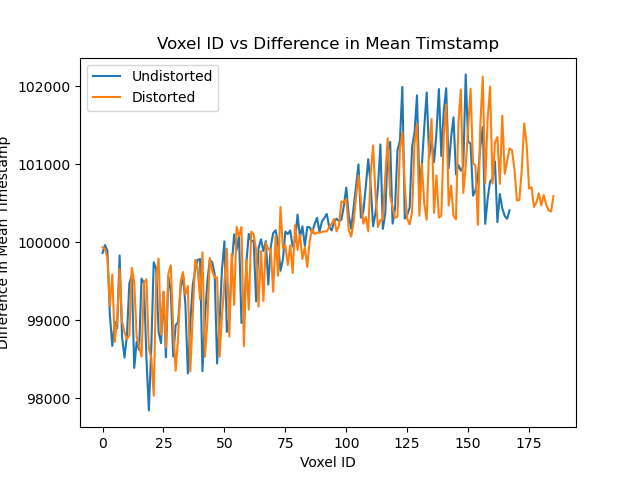

In [55]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

ax.set_title("Voxel ID vs Difference in Mean Timstamp")
ax.set_ylabel("Difference in Mean Timestamp")
ax.set_xlabel("Voxel ID")
ax.plot(UD, label = "Undistorted")
ax.plot(D, label = "Distorted")
ax.legend(loc = "best")

# Get true transform using EgomotionProvider()

(1800, 4, 4)


<IPython.core.display.Javascript object>


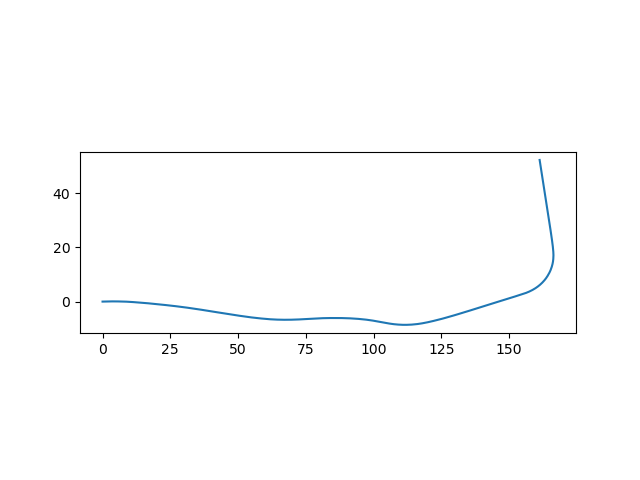

In [189]:
provider = pf.egomotion_provider
# type(provider)
# frame_idx = 220
# time_range = pf['ouster64_bfc_xyzit'][frame_idx].get_field('t')

# print(provider.get_timestamps())
time_range = provider.get_timestamps()
traj1 = provider.get_trajectory(time_range, subsampling = 1) #subsampling is inverted
print(np.shape(traj1))

fig,ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(traj1[:,0,-1], traj1[:,1,-1])

T = np.eye(4)
test = np.zeros([len(traj1), 2])
for idx, i in enumerate(traj1):
#     print(i)
    T = T * i
    test[idx,0] = T[0,-1]
    test[idx,1] = T[1,-1]
    
ax.plot(test[:,0], test[:,1])
# ax.plot(ICET_ENU[:,0], ICET_ENU[:,1])

In [98]:
#TEST- get ground truth bf movement
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/peakcan_fcc_Speed/"
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_navposvel/"
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_ekfeuler/"

prefix = "/media/derm/06EF-127D3/leddartech/" + drive + "/sbgekinox_bcc_gps1pos/"
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_gps1pos/" #what we want
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_gps1vel/"

fn1 = prefix + "00000000.pkl"
with open(fn1, 'rb') as f:
    data = pickle.load(f)

# print(np.shape(data))
print(data[0])

# data = np.asarray(data.tolist())
# print(np.shape(data))
# print(data[238])

(3834125408, 111040, 226257200, 45.50583445, -73.55848726, 17.81922016, -31.6, 0.02090154, 0.00974209, 0.03185664, 11, 19, 120)


<IPython.core.display.Javascript object>


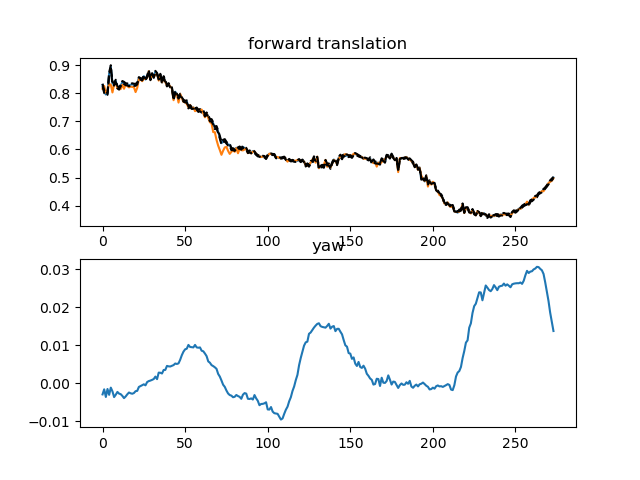

[2.23602518e-03 2.30074697e-03 1.79526920e-04 1.99071601e-05
 3.06149050e-05 1.21379722e-04]


Text(0.5, 1.0, 'yaw')

In [149]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)

# x_hist = np.loadtxt("leddartech_ICET_estimates.txt")
# pred_stds = np.loadtxt("leddartech_ICET_pred_stds.txt")

x_hist = np.loadtxt("results/leddartech_ICET_estimates_v2.txt")
pred_stds = np.loadtxt("results/leddartech_ICET_pred_stds_v2.txt") 
x_hist_NDT = np.loadtxt("results/leddartech_NDT_estimates.txt")


print(pred_stds[0])
ax[0].plot(x_hist[:,0])
ax[0].plot(x_hist_NDT[:,0])
ax[0].plot(x_hist[:,0]+ 2*pred_stds[:,0], c = 'k', ls = '--')
ax[0].plot(x_hist[:,0]- 2*pred_stds[:,0], c = 'k', ls = '--')
ax[0].set_title("forward translation")
ax[1].plot(x_hist[:,5])
ax[1].set_title("yaw")

In [150]:
20 * np.tan(0.05)

1.000834167510776

# Exploring Leddertech Pixset with pioneer-das-api

In [151]:
from pioneer.das.api.platform import Platform

# dataset_path = "/media/derm/06EF-127D2/leddartech/20200721_144638_part36_1956_2229"
# config_path = "/media/derm/06EF-127D2/leddartech/20200721_144638_part36_1956_2229/platform.yml"
dataset_path = "/media/derm/06EF-127D3/leddartech/" + drive
config_path = "/media/derm/06EF-127D3/leddartech/" + drive + "/platform.yml"
pf = Platform(dataset_path, config_path)
# pf.add_egomotion_provider #TODO- figure out if I need this??

Loading sensors: 100%|████████████████████████████| 9/9 [00:00<00:00, 52.65it/s]


In [152]:
#TEST - pioneer das api UNDISTORT FUNCTION???
frame = 100
#LeddarTech Echo sample
ech_sample = pf['pixell_bfc_ech'][frame]
point_cloud = ech_sample.get_point_cloud()
# print(np.shape(point_cloud))

# Ouster PC
lidar_unit = pf['ouster64_bfc_xyzit'][frame]
print(lidar_unit.timestamp)
pc_undistorted = lidar_unit.get_point_cloud(undistort=True)
pc_distorted = lidar_unit.get_point_cloud(undistort=False)
print(np.shape(pc_test))

sync = pf.synchronized()
print(sync)

plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

disp.append(Points(pc_distorted, r = 2, c = 'red'))
disp.append(Points(pc_undistorted, r = 2, c = 'blue'))
# disp.append(Points(data1, r = 5, alpha = 0.2, c = 'gray')) #What I was using


plt1.show(disp, "Fig LedderTech")
ViewInteractiveWidget(plt1.window)


1595343067826196


NameError: name 'pc_test' is not defined

In [153]:
# import pioneer.das.api as api
# api.sensors.imu_sbg_ekinox.IMUEgomotionProvider.(GNSS, pf)
test = pf.add_egomotion_provider
test = pf.egomotion_provider
# print(test.ekfeuler)
print(len(test.get_timestamps()))
test.get_first_inverse_transform()
print("\n forward transform: \n", test.get_transform(10))
# print("\n inverse transform: \n", test.get_inverse_transform(10))
# https://github.com/leddartech/pioneer.das.api/blob/master/pioneer/das/api/egomotion/egomotion_provider.py
# from pioneer.das.api import egomotion
# from abc import ABC, abstractclassmethod
# from pioneer.das.api.egomotion import EgomotionProvider as ep

1800

 forward transform: 
 [[ 7.89267295e-01  6.12699409e-01 -4.07009866e-02  6.12615967e+05]
 [-6.13283946e-01  7.89858779e-01 -2.43125927e-03  5.04015121e+06]
 [ 3.06584004e-02  2.68801751e-02  9.99168414e-01  1.65464702e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [154]:
print("\n pf keys: \n",pf.sensors.keys())
GNSS = pf.sensors['sbgekinox_bcc']
print("\n GNSS keys: \n", GNSS.keys())
ground_truth = GNSS['ekfeuler']
# ground_truth = GNSS['gps1pos']
# print(ground_truth)
# len(list(ground_truth))
LIDAR = pf.sensors['ouster64_bfc']
print("\n LIDAR keys: \n", LIDAR.keys())
print("\n",LIDAR['xyzit'])
# ground_truth.sample_factory(0, )


 pf keys: 
 dict_keys(['peakcan_fcc', 'pixell_bfc', 'flir_bfr', 'flir_bfc', 'flir_bfl', 'flir_bbfc', 'ouster64_bfc', 'sbgekinox_bcc', 'radarTI_bfc'])

 GNSS keys: 
 dict_keys(['status', 'gps1hdt', 'time', 'gps1pos', 'ekfeuler', 'gps1vel', 'navposvel', 'timeus', 'imudata'])

 LIDAR keys: 
 dict_keys(['xyzit', 'temp', 'xyzit-voxmap', 'xyzit-rgb', 'xyzit-voxmap-rgb'])



### Get LIDAR and GNSS/INS timestamps

In [155]:
# print(test.get_timestamps())
num_frames = 274
lidar_time = np.zeros([num_frames])
for i in range(num_frames):
    #church, old Montreal
#     prefix = "/media/derm/06EF-127D2/leddartech/20200721_144638_part36_1956_2229/ouster64_bfc_xyzit/"
    prefix = "/media/derm/06EF-127D3/leddartech/"+ drive + "/ouster64_bfc_xyzit/"
    fn1 = prefix + '%08d.pkl' %(i)
    with open(fn1, 'rb') as f:
        data1 = pickle.load(f)
    lidar_time[i] = np.asarray(data1.tolist())[0,-1]
#     data1 = np.asarray(data1.tolist())[:,:3]
# print(lidar_time[1] - lidar_time[0])
# print(len(timestamps))

x_hist = np.loadtxt("results/leddartech_ICET_estimates_v2.txt") #old church
# x_hist = np.loadtxt("results/leddartech_ICET_estimates_suburb.txt") #old pc gathernig method
# x_hist = np.loadtxt("results/leddartech_ICET_estimates_suburb_undistorted.txt") #new strategy

<IPython.core.display.Javascript object>


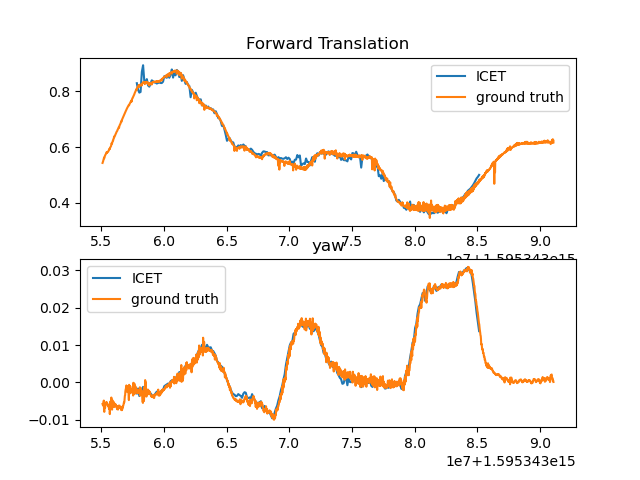

In [156]:
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from scipy.spatial.transform import Rotation as R
name = pf
test = emp(name, GNSS['navposvel'], GNSS['ekfeuler'])
timestamps = test.get_timestamps()
T1 = test.get_transform(timestamps[1])
T2 = test.get_transform(timestamps[2])

from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
gt_vec = np.zeros([1800-1,6])

for i in range(1,1800):
    #get translations from GNSS/INS baseline
    gt_vec[i-1,0] = test.get_transform(timestamps[i])[1,3] - test.get_transform(timestamps[i-1])[1,3]
    gt_vec[i-1,1] = test.get_transform(timestamps[i])[0,3] - test.get_transform(timestamps[i-1])[0,3]
    gt_vec[i-1,2] = test.get_transform(timestamps[i])[2,3] - test.get_transform(timestamps[i-1])[2,3]
    #get rotations
    T1 = test.get_transform(timestamps[i-1])
    T2 = test.get_transform(timestamps[i])
    r1 = R.from_matrix(T1[:3,:3])
    r2 = R.from_matrix(T2[:3,:3])
    gt_vec[i-1,3:] = (r2.as_euler('xyz', degrees=False) - r1.as_euler('xyz', degrees=False))
    
vf = np.sqrt(gt_vec[:,0]**2 + gt_vec[:,1]**2)
gt_vec[:,0] = vf
gt_vec[:,1] = 0
gt_vec[:,2] = 0

gt_vec = gt_vec*5

# ax.plot(x_hist[:,0], label = "ICET")
# ax.plot(5*gt, label = "ground truth")
ax[0].set_title("Forward Translation")
ax[0].plot(lidar_time, x_hist[:,0], label = "ICET")
ax[0].plot(timestamps[:-1], gt_vec[:,0], label = "ground truth")
ax[0].legend(loc='best')
ax[1].set_title("yaw")
ax[1].plot(lidar_time, x_hist[:,5], label = "ICET")
ax[1].plot(timestamps[:-1], gt_vec[:,5], label = 'ground truth')
# ax[1].scatter(lidar_time[idx], x_hist[idx,5], color = 'r', label = "Point of linearization")

ax[1].legend(loc='best')

In [157]:

#get closest partof 
yaw_error = closest_gt_yaw - x_hist[:,5]
yaw_thresh = 0.0025
bad_yaw_idx = np.argwhere(np.abs(yaw_error) > yaw_thresh)


x_error = closest_gt_x - x_hist[:,1]
x_thresh = 0.08
bad_x_idx = np.argwhere(np.abs(x_error) > x_thresh)
# print(bad_x_idx)

NameError: name 'closest_gt_yaw' is not defined

In [ ]:
#For trainig data generation script: 
#given lidar index, <idx>, find solution vector for closest corresponding timestamp in GNSS/INS 

idx = 100
prefix = "/media/derm/06EF-127D3/leddartech/"+ drive + "/ouster64_bfc_xyzit/"
fn1 = prefix + '%08d.pkl' %(idx)
with open(fn1, 'rb') as f:
    data1 = pickle.load(f)
ts_lidar = np.asarray(data1.tolist())[0,-1]
print(ts_lidar)

# loop through all GNSS timestamps, stop when larger than ts_lidar and use previous index
for c in range(len(timestamps)):
    ts_gnss = timestamps[c]
    if ts_gnss > ts_lidar:
        break
x0 = tf.convert_to_tensor(gt_vec[c], dtype = tf.float32)
print(x0)

In [ ]:
#plot sample idx vs time"
fig, ax = plt.subplots()
for idx in range(1,100,10):
    prefix = "/media/derm/06EF-127D3/leddartech/"+ drive + "/ouster64_bfc_xyzit/"
    fn1 = prefix + '%08d.pkl' %(idx)
    with open(fn1, 'rb') as f:
        data1 = pickle.load(f)
    ts_lidar = np.asarray(data1.tolist())[0,-1]
    print(ts_lidar)

    #NOT A STRAIGHT LINE!
    ax.plot(np.asarray(data1.tolist())[:,4] - np.asarray(data1.tolist())[0,4]  ) 
    ax.set_xlabel("scan point processed")
    ax.set_ylabel("timestamp")

## Plot ICET vs Ground Truth on LeddarTech PixSet

<IPython.core.display.Javascript object>


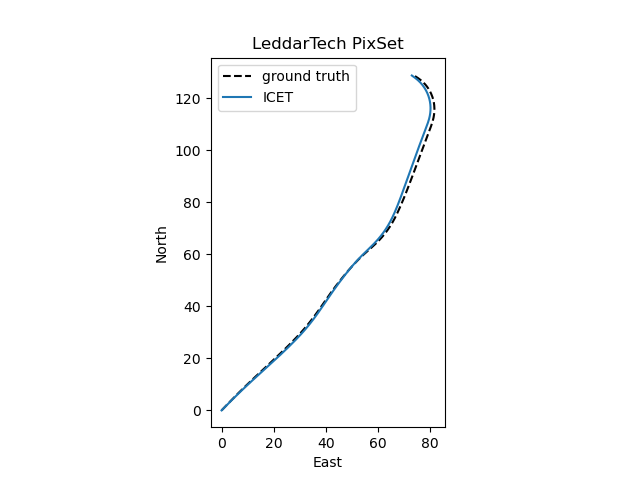

In [158]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel("East")
ax.set_ylabel("North")
ax.set_title("LeddarTech PixSet")

ground_truth_ENU = np.zeros([len(test.get_timestamps()),3])
for i in range(len(test.get_timestamps())):
    ground_truth_ENU[i,0] = -test.get_transform(timestamps[i])[1,3]
    ground_truth_ENU[i,1] = test.get_transform(timestamps[i])[0,3]
    ground_truth_ENU[i,2] = test.get_transform(timestamps[i])[2,3] #test
    
#truncate ground truth to length of LIDAR data
ground_truth_ENU = ground_truth_ENU[140:,:]
# ground_truth_ENU = ground_truth_ENU[:-265,:] #old
ground_truth_ENU = ground_truth_ENU[:-250,:] #test

#convert sequential ICET estimates to ENU
ICET_cum = np.zeros(np.shape(x_hist))
NDT_cum = np.zeros(np.shape(x_hist_NDT))
for k in range(len(x_hist)):
    ICET_cum[k] = np.sum(x_hist[:k], axis=0)
    NDT_cum[k] = np.sum(x_hist_NDT[:k], axis=0)

ICET_cum[:,5] += 0.8 #correct total yaw to line up with ENU at initial pose
# NDT_cum[:,5] += 0.8

ICET_ENU = np.zeros([len(x_hist), 3])
NDT_ENU = np.zeros([len(x_hist), 3])
for j in range(1,len(x_hist)):
    ICET_ENU[j, 0] = ICET_ENU[j-1, 0] + x_hist[j,0]*np.cos(ICET_cum[j,5])
    ICET_ENU[j, 1] = ICET_ENU[j-1, 1] + x_hist[j,0]*np.sin(ICET_cum[j,5])
    
    NDT_ENU[j, 0] = NDT_ENU[j-1, 0] + x_hist_NDT[j,0]*np.cos(NDT_cum[j,5])
    NDT_ENU[j, 1] = NDT_ENU[j-1, 1] + x_hist_NDT[j,0]*np.sin(NDT_cum[j,5])
    
    
ground_truth_ENU[:,:] -= ground_truth_ENU[0,:] #zero out start
ax.plot(ground_truth_ENU[:-20,0], ground_truth_ENU[:-20,1], 'k--', label = "ground truth")

ax.plot(ICET_ENU[:,0], ICET_ENU[:,1], label = 'ICET')
# ax.plot(NDT_ENU[:,0], NDT_ENU[:,1], label = 'NDT')
ax.legend(loc = 'best')

# print(ICET_ENU)

### Plot 3D trajectory of ICET estimates vs Ground Truth

In [125]:
from utils import R_tf

axlabel  = {"xtitle": "East (m)",
            "ytitle": "North (m)",
            "ztitle": "Up (m)"}
plt2 = Plotter(N = 1, bg = (1, 1, 1), interactive = True)
# plt2 = Plotter(N = 1, bg = (0.2, 0.2, 0.2), interactive = True) 
# plt2 = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 1
disp = []

#snail trail for ICET estimates and HD-Map
snail_trail_ICET = np.zeros([1,3])
snail_trail_NDT = np.zeros([1,3])
# HD_map = np.zeros([1,3])
for i in range(len(x_hist)):
#     print(i)
    snail_trail_ICET += x_hist[i,:3]
    rot = R_tf(np.array([x_hist[i,3], x_hist[i,4], -x_hist[i,5]])).numpy()
    snail_trail_ICET = snail_trail_ICET.dot(rot)    
    snail_trail_ICET = np.append(np.zeros([1,3]), snail_trail_ICET, axis = 0)

    snail_trail_NDT += x_hist_NDT[i,:3]
    rot_NDT = R_tf(np.array([x_hist_NDT[i,3], x_hist_NDT[i,4], -x_hist_NDT[i,5]])).numpy()
    snail_trail_NDT = snail_trail_NDT.dot(rot_NDT)    
    snail_trail_NDT = np.append(np.zeros([1,3]), snail_trail_NDT, axis = 0)
    
#     #loop through all point clouds to make single mega cloud
#     prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/ouster64_bfc_xyzit/" #very good quality
#     fn1 = prefix + '%08d.pkl' %(i)
#     with open(fn1, 'rb') as f:
#         data1 = pickle.load(f)
#         local_PC = np.asarray(data1.tolist())[:,:3]    
#         local_PC = local_PC[np.random.choice(len(local_PC), size = 20000)]  #downsample

#     HD_map -= x_hist[i,:3]
#     rot_map = R_tf(np.array([-x_hist[i,3], -x_hist[i,4], -x_hist[i,5]])).numpy()
#     HD_map = HD_map.dot(rot_map)
#     HD_map = np.append(local_PC, HD_map, axis = 0)
    
snail_trail_ICET -= snail_trail_ICET[-1,:] #set common origin 
# HD_map -= snail_trail_ICET[0,:]
## HD_map[:,:2] -= snail_trail_ICET[0,:2] #test
rotation_correction_ICET = R_tf(np.array([0, -0.15, -0.59])).numpy()
snail_trail_ICET = snail_trail_ICET.dot(rotation_correction_ICET)
snail_trail_ICET_points_obj = Points(snail_trail_ICET, c = 'red', r = 5, alpha = 1).legend("ICET")
disp.append(snail_trail_ICET_points_obj)

snail_trail_NDT -= snail_trail_NDT[-1,:] #set common origin 
snail_trail_NDT = snail_trail_NDT.dot(rotation_correction_ICET)
snail_trail_NDT_points_obj = Points(snail_trail_NDT, c = 'green', r = 5, alpha = 1).legend("NDT")
disp.append(snail_trail_NDT_points_obj)

#snail trail for ground truth
gt = ground_truth_ENU[20:]
gt = gt-gt[0]
gt_points_obj = Points(gt, c = 'blue', r = 3, alpha = 1).legend("GPS/INS Baseline")
disp.append(gt_points_obj)
         

# rotation_correction_HD_map = R_tf(np.array([0, -0.15, -0.59 + np.pi])).numpy()
# HD_map = HD_map.dot(rotation_correction_HD_map)
HD_map_temp = HD_map.copy()
HD_map_temp[:,2] -= 6.5 #1.5
HD_map_temp = HD_map_temp.dot(R_tf(np.array([0, 0.05, 0])).numpy()) #old
# HD_map_temp = HD_map_temp.dot(R_tf(np.array([0.025, 0.1, 0])).numpy()) #test
HD_map_temp = HD_map_temp[HD_map_temp[:,0] > -15 ] #crop
HD_map_temp = HD_map_temp[HD_map_temp[:,0] < 100 ] 
HD_map_temp = HD_map_temp[HD_map_temp[:,1] > -15 ] 
HD_map_temp = HD_map_temp[HD_map_temp[:,1] < 150 ] 

#rainbow by z height
# zheight = 100*(np.sin(0.25*HD_map_temp[:,2])+3)
# cname = np. array([zheight, 100*(np.sin(0.25*HD_map_temp[:,2]+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# points_object = Points(HD_map_temp, c = cname, r = 1.0, alpha = 0.02)
# disp.append(points_object)

disp.append(Points(HD_map_temp, c = "black", r = 0.25, alpha = 0.03))

lb = LegendBox([snail_trail_NDT_points_obj, snail_trail_ICET_points_obj, gt_points_obj], width=0.15, height=0.15, markers='s').font("Kanopus")

plt2.show(disp, lb, "LeddarTech PixSet", axes = axlabel)
# plt2.show(disp, lb, "LeddarTech PixSet")
ViewInteractiveWidget(plt2.window)

NameError: name 'x_hist_NDT' is not defined

In [ ]:
snail_trail_ICET[0,:]

# Using Ouster Sample Dataset and Ouster-SDK

In [141]:
import pandas as pd
from utils import R_tf
fn1 = "/media/derm/06EF-127D3/Ouster/csv/pcap_out_000120.csv"
df1 = pd.read_csv(fn1, sep=',', skiprows=[0])
pc1 = df1.values[:,8:11]*0.001 #1st return
# pc1 = df1.values[:,11:14]*0.001 #2nd return
# print(pc1)
fn2 = "/media/derm/06EF-127D3/Ouster/csv/pcap_out_000125.csv"
df2 = pd.read_csv(fn2, sep=',', skiprows=[0])
pc2 = df2.values[:,8:11]*0.001

# pc1 = pc1[pc1[:,2] > -1.25] #ignore ground plane
# pc2 = pc2[pc2[:,2] > -1.25] #ignore ground plane

# T = np.array([0.124,0.,0.]) #ground truth transform for scans 0,1
# pc2 += T
T = np.array([1.577,0.,0.]) #120, 125
rot = R_tf(np.array([0.,0.,-0.133])).numpy()
pc2 = (pc2 + T).dot(rot)

signal_miss_idx = np.where(pc1 == np.array([0., 0., 0.]))
print(np.shape(signal_miss_idx[0]))

(72548,)


In [142]:
plt2 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

# #color by z height
# # zheight = (15*(pc1[:,2]+3)) #was this
# # cname = np.array([zheight, 80*np.ones(len(zheight)), 80*np.ones(len(zheight))]).T.tolist()
# zheight = 100*(np.sin(0.5*pc1[:,2])+1) #test
# cname = np.array([zheight, 100*(np.sin(0.5*pc1[:,2]+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# print(zheight)
# points_object1 = Points(pc1, c = cname, r = 5, alpha = 0.5)
# disp.append(points_object1)

#constant color
disp.append(Points(pc1, c = 'red', r = 2.5, alpha = 1)) 
disp.append(Points(pc2, c = 'blue', r = 2.5, alpha = 1)) 
plt2.show(disp, "Fig Ouster")
ViewInteractiveWidget(plt2.window)

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [143]:
x_init = tf.constant([0.5, 0., 0., 0., 0., 0.])
it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 5, 
           draw = True, group = 2, RM = False, DNN_filter = False, x0 = x_init)
ViewInteractiveWidget(it.plt.window)


 estimated solution vector X: 
 tf.Tensor([ 0.01303939  0.00507952  0.04073006 -0.00684182  0.00859935 -0.00073759], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


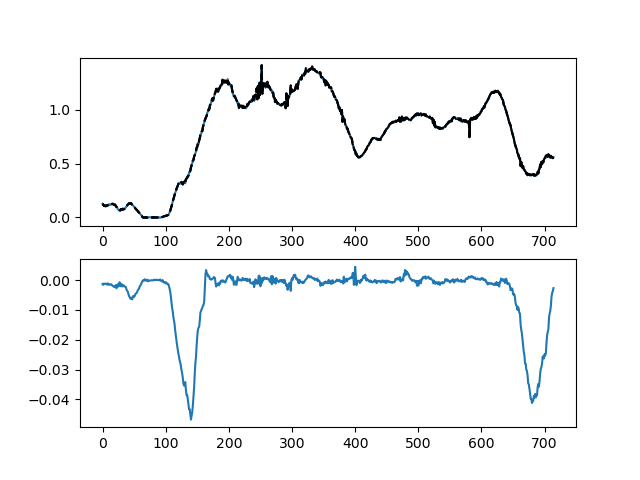

[9.37603239e-04 1.51472515e-04 7.09558008e-05 1.47759256e-05
 1.12411872e-05 3.30858784e-05]


In [144]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)

x_hist = np.loadtxt("ouster_ICET_estimates.txt")
pred_stds = np.loadtxt("ouster_ICET_pred_stds.txt")
print(pred_stds[0])

ax[0].plot(x_hist[:,0])
ax[0].plot(x_hist[:,0]+ 2*pred_stds[:,0], c = 'k', ls = '--')
ax[0].plot(x_hist[:,0]- 2*pred_stds[:,0], c = 'k', ls = '--')
ax[1].plot(x_hist[:,5])

In [147]:
#read in raw PCAP files directly from Ouster Sample dataset
#  need to use ouster-sdk (not as good as velodyne)
from ouster import pcap
from ouster.pcap import _pcap
from ouster import client
from ouster.client import _client

pcap_path = "/media/derm/06EF-127D3/Ouster/OS-1-128_v2.3.0_1024x10_20220419_160551-000.pcap"
metadata_path = '/media/derm/06EF-127D3/Ouster/OS-1-128_v2.3.0_1024x10_20220419_160551.json'



with open(metadata_path, 'r') as f:
    metadata = client.SensorInfo(f.read())

source = pcap.Pcap(pcap_path, metadata)


In [131]:
# pcap_to_csv(source, metadata)

In [137]:
from typing import Tuple, List

def pcap_to_csv(source: client.PacketSource,
                metadata: client.SensorInfo,
                num: int = 0,
                csv_dir: str = ".",
                csv_base: str = "pcap_out",
                csv_ext: str = "csv") -> None:
    """Write scans from a pcap to csv files (one per lidar scan).

    The number of saved lines per csv file is always H x W, which corresponds to
    a full 2D image representation of a lidar scan.

    Each line in a csv file is (for LEGACY profile):

        TIMESTAMP, RANGE (mm), SIGNAL, NEAR_IR, REFLECTIVITY, X (mm), Y (mm), Z (mm)

    If ``csv_ext`` ends in ``.gz``, the file is automatically saved in
    compressed gzip format. :func:`.numpy.loadtxt` can be used to read gzipped
    files transparently back to :class:`.numpy.ndarray`.

    Args:
        source: PacketSource from pcap
        metadata: associated SensorInfo for PacketSource
        num: number of scans to save from pcap to csv files
        csv_dir: path to the directory where csv files will be saved
        csv_base: string to use as the base of the filename for pcap output
        csv_ext: file extension to use, "csv" by default
    """

    dual = False
    if metadata.format.udp_profile_lidar == client.UDPProfileLidar.PROFILE_LIDAR_RNG19_RFL8_SIG16_NIR16_DUAL:
        dual = True
        print("Note: You've selected to convert a dual returns pcap to CSV. Each row "
              "will represent a single pixel, so that both returns for that pixel will "
              "be on a single row. As this is an example we provide for getting "
              "started, we realize that you may have conversion needs which are not met "
              "by this function. You can find the source code on the Python SDK "
              "documentation website to modify it for your own needs.")

    # ensure that base csv_dir exists
    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)

    # construct csv header and data format
    def get_fields_info(scan: client.LidarScan) -> Tuple[str, List[str]]:
        field_names = 'TIMESTAMP (ns)'
        field_fmts = ['%d']
        for chan_field in scan.fields:
            field_names += f', {chan_field}'
            if chan_field in [client.ChanField.RANGE, client.ChanField.RANGE2]:
                field_names += ' (mm)'
            field_fmts.append('%d')
        field_names += ', X (mm), Y (mm), Z (mm)'
        field_fmts.extend(3 * ['%d'])
        if dual:
            field_names += ', X2 (mm), Y2 (mm), Z2 (mm)'
            field_fmts.extend(3 * ['%d'])
        return field_names, field_fmts

    field_names: str = ''
    field_fmts: List[str] = []

    # [doc-stag-pcap-to-csv]
    from itertools import islice
    # precompute xyzlut to save computation in a loop
    xyzlut = client.XYZLut(metadata)

    # create an iterator of LidarScans from pcap and bound it if num is specified
    scans = iter(client.Scans(source))
    if num:
        scans = islice(scans, num)

    for idx, scan in enumerate(scans):

        # initialize the field names for csv header
        if not field_names or not field_fmts:
            field_names, field_fmts = get_fields_info(scan)

        # copy per-column timestamps for each channel
        timestamps = np.tile(scan.timestamp, (scan.h, 1))

        # grab channel data
        fields_values = [scan.field(ch) for ch in scan.fields]

        # use integer mm to avoid loss of precision casting timestamps
        xyz = (xyzlut(scan.field(client.ChanField.RANGE)) * 1000).astype(
            np.int64)

        if dual:
            xyz2 = (xyzlut(scan.field(client.ChanField.RANGE2)) * 1000).astype(
                np.int64)

            # get all data as one H x W x num fields int64 array for savetxt()
            frame = np.dstack((timestamps, *fields_values, xyz, xyz2))

        else:
            # get all data as one H x W x num fields int64 array for savetxt()
            frame = np.dstack((timestamps, *fields_values, xyz))

        # not necessary, but output points in "image" vs. staggered order
        frame = client.destagger(metadata, frame)

        # write csv out to file
        csv_path = os.path.join(csv_dir, f'{csv_base}_{idx:06d}.{csv_ext}')
        print(f'write frame #{idx}, to file: {csv_path}')

        header = '\n'.join([f'frame num: {idx}', field_names])

        np.savetxt(csv_path,
                   frame.reshape(-1, frame.shape[2]),
                   fmt=field_fmts,
                   delimiter=',',
                   header=header)

    # [doc-etag-pcap-to-csv]

In [138]:
def xyz_proj(metadata: client.SensorInfo,
             scan: client.LidarScan) -> np.ndarray:
    """Computes a point cloud from a scan as numpy array.

    This is a reference implementation that follows the calculations from
    `Section 3.1.2`_ of the Software User Manual exactly. Output is a point
    cloud in the *sensor frame* with points arranged in column-major order,
    with coordinates in meters.

    Args:
        metadata: Sensor metadata associated with the scan
        scan: A frame of lidar data

    Returns:
        A H x W x 3 array of point coordinates

    .. _Section 3.1.2: https://data.ouster.io/downloads/software-user-manual/software-user-manual-v2p0.pdf#a
    """
#     https://static.ouster.dev/sdk-docs/_modules/ouster/sdk/examples/reference.html#xyz_proj

    # use homogeneous coordinates for convenient transformation
    xyz = np.zeros((scan.w * scan.h, 4))

    # iterate over each measurement channel/row and measurement block/column
    for u, v in product(range(scan.h), range(scan.w)):

        r = scan.field(client.ChanField.RANGE)[u, v]
        n = metadata.lidar_origin_to_beam_origin_mm

        # scans are always a full frame, so the measurement id is also the index
        assert scan.measurement_id[v] == v

        theta_encoder = 2.0 * pi * (1.0 - v / scan.w)
        theta_azimuth = -2.0 * pi * (metadata.beam_azimuth_angles[u] / 360.0)
        phi = 2.0 * pi * (metadata.beam_altitude_angles[u] / 360.0)

        # zero ranges represent no return; avoid applying offsets to these
        if r == 0.0:
            continue

        # compute point coordinates in the lidar frame
        x = (r - n) * cos(theta_encoder +
                          theta_azimuth) * cos(phi) + n * cos(theta_encoder)
        y = (r - n) * sin(theta_encoder +
                          theta_azimuth) * cos(phi) + n * sin(theta_encoder)
        z = (r - n) * sin(phi)

        # insert into xyz; point order is row-major to match input scan
        xyz[u * scan.w + v] = [x, y, z, 1]

    # transform from lidar to sensor frame and scale to meters
    xyz_sensor = xyz @ metadata.lidar_to_sensor_transform.T
    return xyz_sensor[:, :3].reshape(scan.h, scan.w, 3) * 0.001

In [139]:
#suggested method of reading pcap files Ouster unit
for packet in source:
    if isinstance(packet, client.LidarPacket):
        # Now we can process the LidarPacket. In this case, we access
        # the measurement ids, timestamps, and ranges
        measurement_ids = packet.measurement_id
        timestamps = packet.timestamp
        ranges = packet.field(client.ChanField.RANGE)
        print(f'  encoder counts = {measurement_ids.shape}')
        print(f'  timestamps = {timestamps.shape}')
        print(f'  ranges = {ranges.shape}')

    elif isinstance(packet, client.ImuPacket):
        # and access ImuPacket content
        print(f'  acceleration = {packet.accel}')
        print(f'  angular_velocity = {packet.angular_vel}')


NameError: name 'source' is not defined

In [140]:
for packet in source:
#     print(packet)
    if isinstance(packet, client.LidarPacket):
        test = packet
        print("Done")
        break


NameError: name 'source' is not defined

In [136]:
idx = 1
fn1 = prefix + '%08d.pkl' %(idx)
print(fn1)

/media/derm/06EF-127D3/leddartech/20200721_144638_part36_1956_2229/ouster64_bfc_xyzit/00000001.pkl
